In [203]:
import re
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from collections import defaultdict

def load_uses(filename='TRoTR/data/uses.tsv', sep='\t'):
    tmp = list()
    with open(filename, mode='r', encoding='utf-8') as f:
        columns = f.readline().rstrip().split(sep)
        for line in f.readlines():
            tmp.append(dict(zip(columns, line.rstrip().split(sep))))
    
    return pd.DataFrame(tmp)

def load_instances(filename, dirname='TRoTR/rounds', sep='\t'):
    tmp = list()
    with open(f'{dirname}/{filename}', mode='r', encoding='utf-8') as f:
        columns = f.readline().rstrip().split(sep) + ['dataID1', 'dataID2']
        for line in f.readlines():
            tmp_record = dict(zip(columns, line[:-1].split('\t')))
            tmp_record['dataID1'], tmp_record['dataID2'] = tmp_record['dataIDs'].split(',')
            tmp.append(tmp_record)
    
    return pd.DataFrame(tmp)

def load_judgments(filename, dirname='TRoTR/judgments', sep='\t'):
    tmp = list()
    with open(f'{dirname}/{filename}', mode='r', encoding='utf-8') as f:
        columns = f.readline().rstrip().split(sep)
        for line in f.readlines():
            tmp_record = dict(zip(columns, line.rstrip().split(sep)))
            tmp.append(tmp_record)
            
    #tmp - to remove after fixing the bug
    tmp = list()
    with open(f'{dirname}/{filename}', mode='r', encoding='utf-8') as f:
        columns = f.readline().rstrip().split(sep)
        f = f.read().replace('iosakwe\n', 'iosakwe@@@').replace('shur\n', 'shur@@@').replace('Nisha\n', 'Nisha@@@').replace('AndreaMariaC\n', 'AndreaMariaC@@@').replace('\n', '--')
        lines = f.split('@@@')
        for line in lines:
            tmp_record = dict(zip(columns, line.rstrip().split(sep)))
            tmp.append(tmp_record)

    # -1: can not decide
    df = pd.DataFrame(tmp).fillna('-1')
    df['label'] = df['label'].apply(lambda x: x.replace('-', '-1')).astype(int)
    
    return df

def merge_data(df_uses, df_instances, df_judgments):
    df = df_judgments.merge(df_instances).merge(df_uses, left_on='dataID1', right_on='dataID')
    del df['dataID']
    del df['lemma']
    df = df.rename(columns={column: f'{column}1' for column in ['context', 'indices_target_token', 'indices_target_sentence']})
    df = df.merge(df_uses, left_on='dataID2', right_on='dataID')
    del df['dataID']
    df = df.rename(columns={column: f'{column}2' for column in ['context', 'indices_target_token', 'indices_target_sentence']})
    
    column_order = ['instanceID', 'dataID1', 'dataID2', 'label', 'annotator',  'lemma', 'context1', 'context2', 'indices_target_token1', 'indices_target_sentence1', 'indices_target_sentence2', 'indices_target_token2',  'comment', 'label_set', 'non_label', 'dataIDs']
    return df[column_order]

def std_judgments(df, lemma=False):
    dfs = list()

    if not lemma:
        for ann in df.annotator.unique():
            tmp = df[df['annotator']==ann].copy()
            avg = np.mean(tmp.label[tmp.label >= 1].values)
            tmp.label = [i if i!=-1 else avg for i in tmp.label]
            tmp.label = (tmp.label - tmp.label.mean())/(tmp.label.std())
            dfs.append(tmp)
        return pd.concat(dfs)
    if lemma:
        for ann in df.annotator.unique():
            for lemma in df.lemma.unique():
                tmp = df[(df['annotator']==ann) & (df['lemma']==lemma)].copy()
                avg = np.mean(tmp.label[tmp.label >= 1].values)
                tmp.label = [i if i!=-1 else avg for i in tmp.label]
                tmp.label = (tmp.label - tmp.label.mean())/(tmp.label.std())
                dfs.append(tmp)
        return pd.concat(dfs)

round_ = 'TRoTR.tsv'
df_judgments = load_judgments(round_)
available_ids = {re.search('\(.*\)', i).group(0).replace(':', ' ') for i in df_judgments[df_judgments['annotator']!='-1'].instanceID.values}
df_uses = load_uses()
df_uses = df_uses[[re.search('\(.*\)', i).group(0).replace(':', ' ') in available_ids for i in df_uses.dataID.values]]
df_instances = load_instances(round_)
df_instances = df_instances[[re.search('\(.*\)', i).group(0).replace(':', ' ') in available_ids for i in df_instances.instanceID.values]]
df = merge_data(df_uses, df_instances, df_judgments)
df = std_judgments(df, lemma=False)

In [204]:
durel_uses = df_uses.copy()
durel_uses['lemma'] = durel_uses['lemma'].apply(lambda x: x.replace(' ', '_').replace(',', ''))### durel
durel_uses['description'] = ""
durel_uses['pos'] = ""
durel_uses['date'] = ""
durel_uses['grouping'] = ""
durel_uses = durel_uses.rename(columns={'dataID': 'identifier', 'indices_target_sentence': 'indexes_target_sentence', 'indices_target_token': 'indexes_target_token'})
columns = ['lemma', 'pos', 'date', 'grouping', 'identifier', 'description', 'context', 'indexes_target_token', 'indexes_target_sentence']
#durel_uses['indexes_target_sentence'] = [f"0:{len(row['context'])}" for i, row in durel_uses.iterrows()]
durel_uses = durel_uses[columns]


for lemma in durel_uses[columns].lemma.unique():    
    tmp = durel_uses[durel_uses['lemma'] == lemma]
    id_quote = re.search('\(.*\)', tmp.iloc[0].identifier).group(0).replace(':', ' ')
    Path(f'TRoTR/DURel_data/{id_quote}').mkdir(parents=True, exist_ok=True)
    tmp.to_csv(f'TRoTR/DURel_data/{id_quote}/uses.tsv', index=False, sep='\t')
    
    Path(f'TRoTR/DURel_data/uses').mkdir(parents=True, exist_ok=True)
    tmp.to_csv(f'TRoTR/DURel_data/uses/{id_quote}.tsv', index=False, sep='\t')

    df['lemma'] = df['lemma'].apply(lambda x: x.replace(' ', '_').replace(',', ''))### durel
    df['timestamp'] = ''### durel
    durel_judgments = df[df['lemma'] == lemma].copy()    
    durel_judgments = durel_judgments.rename(columns={'dataID1': 'identifier1', 'dataID2': 'identifier2', 'label':'judgment'})
    columns = ['identifier1', 'identifier2', 'annotator', 'judgment', 'comment', 'lemma', 'timestamp']
    durel_judgments = durel_judgments[columns]
    durel_judgments.to_csv(f'TRoTR/DURel_data/{id_quote}/judgments.tsv', index=False, sep='\t')
    
    Path(f'TRoTR/DURel_data/judgments').mkdir(parents=True, exist_ok=True)
    durel_judgments.to_csv(f'TRoTR/DURel_data/judgments/{id_quote}.tsv', index=False, sep='\t')

#durel_uses.to_csv(f'TRoTR/DURel_data/uses.tsv', index=False, sep='\t')
#df.rename(columns={'dataID1': 'identifier1', 'dataID2': 'identifier2', 'label':'judgment'})[columns].to_csv(f'TRoTR/DURel_data/judgments.tsv', index=False, sep='\t')

In [205]:
from scipy.stats import spearmanr
spearmanr(df[df['annotator']=='AndreaMariaC'].sort_values(by='instanceID').label, df[df['annotator']=='Nisha'].sort_values(by='instanceID').label)

SignificanceResult(statistic=0.5878170694134324, pvalue=2.1900530815105282e-195)

In [208]:
tmp = df[df['label']!=-1][['annotator', 'lemma', 'instanceID', 'label']]

<Axes: title={'center': 'label'}, xlabel='[annotator]'>

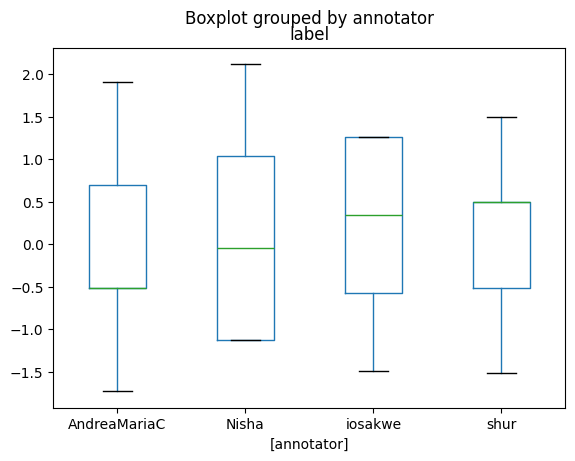

In [209]:
tmp[['annotator', 'label']].boxplot(by='annotator', grid=False)

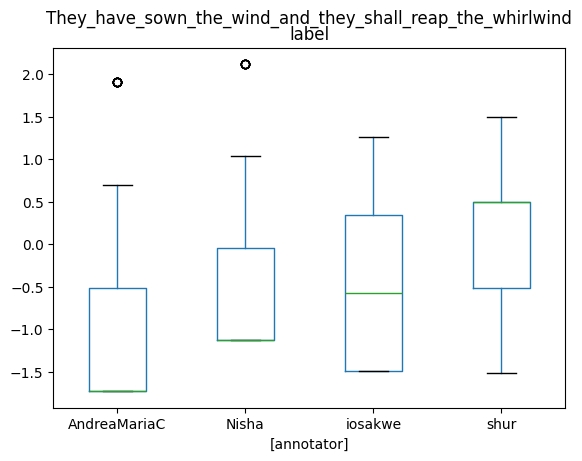

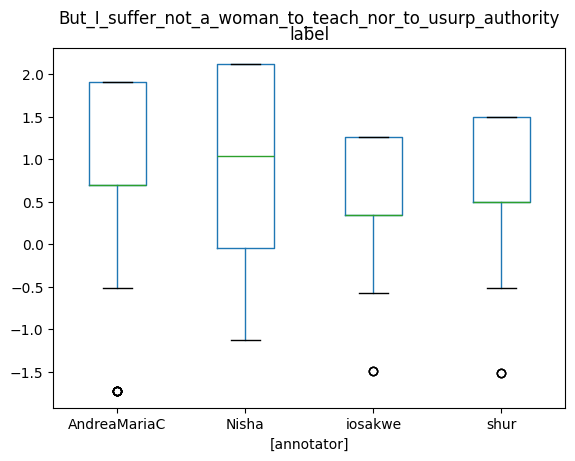

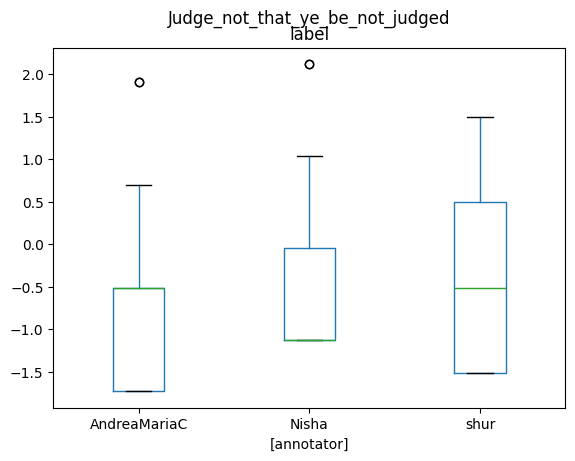

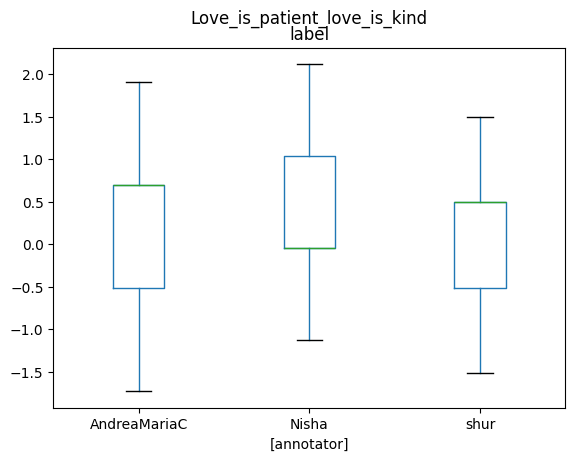

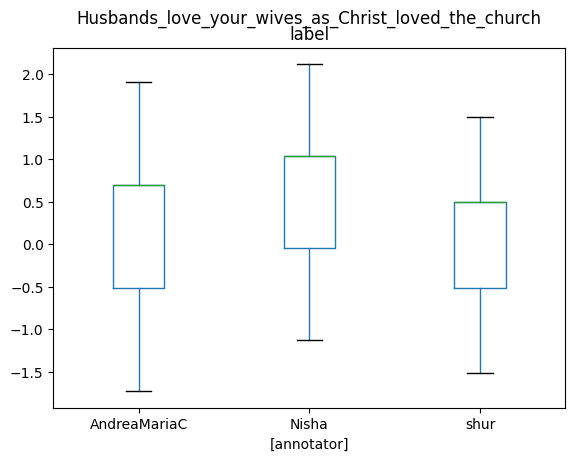

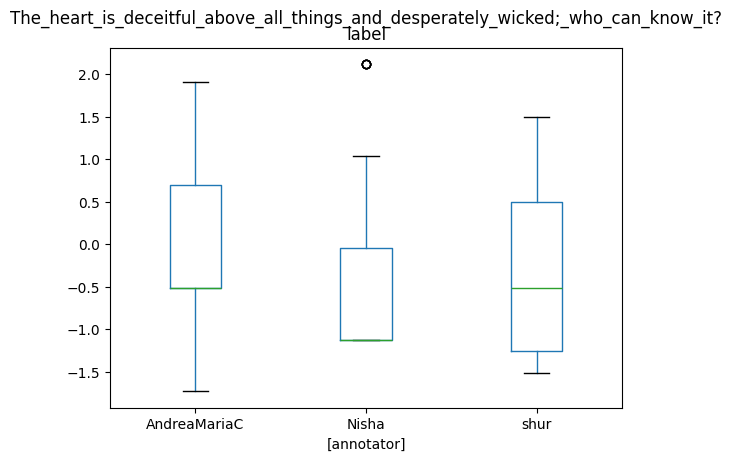

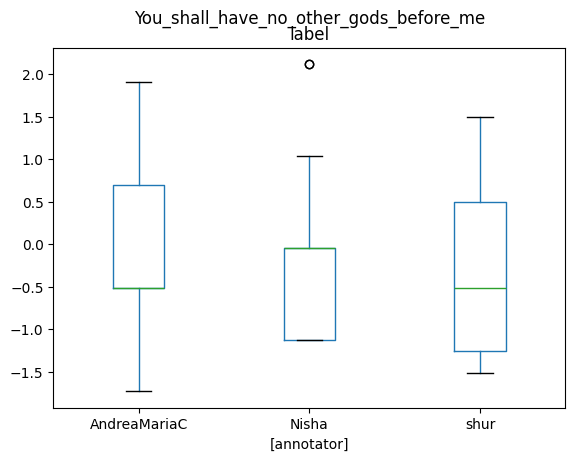

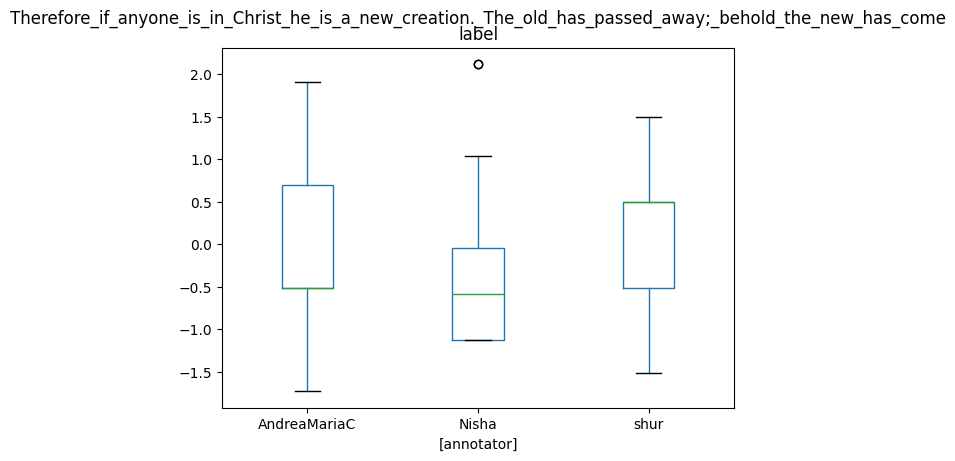

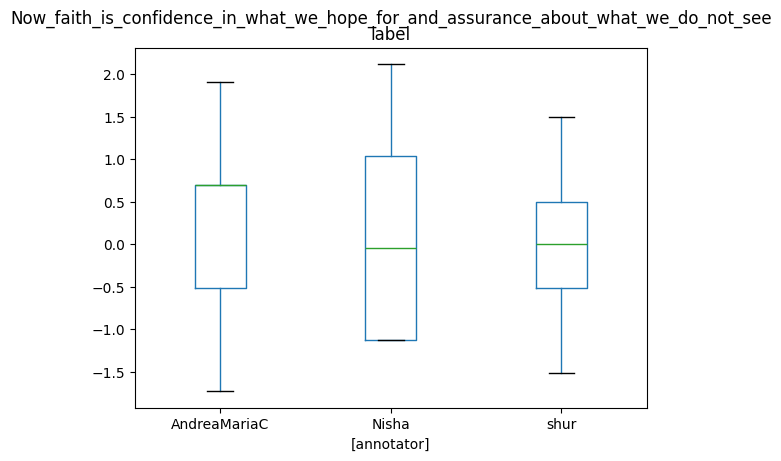

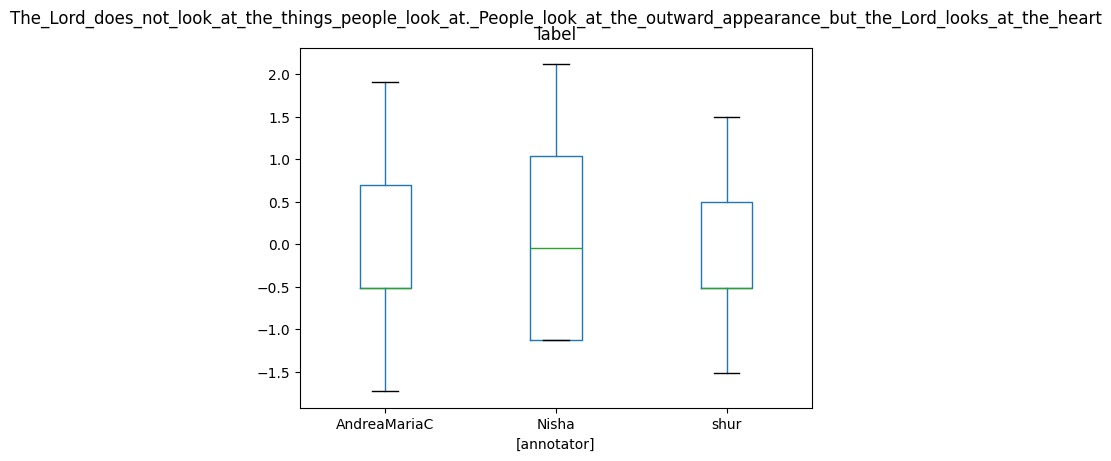

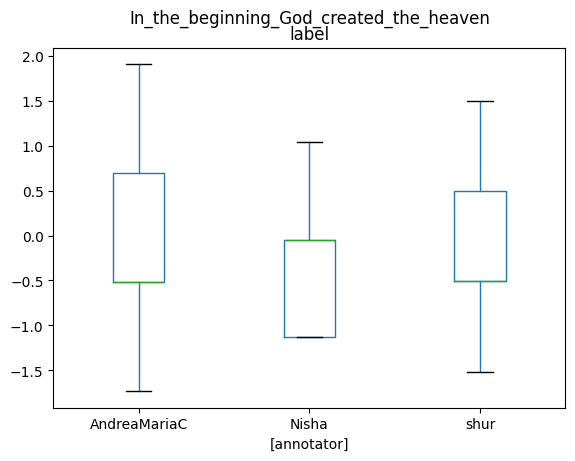

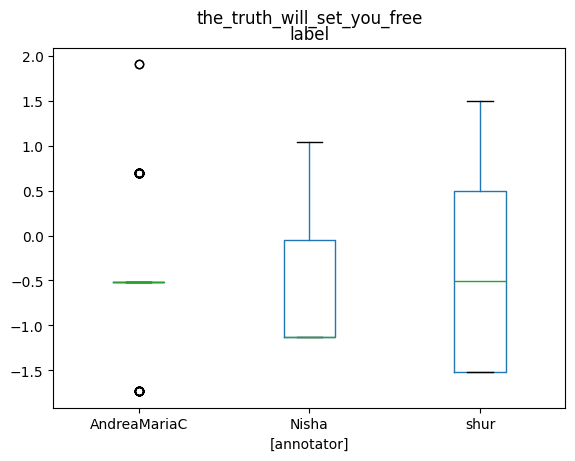

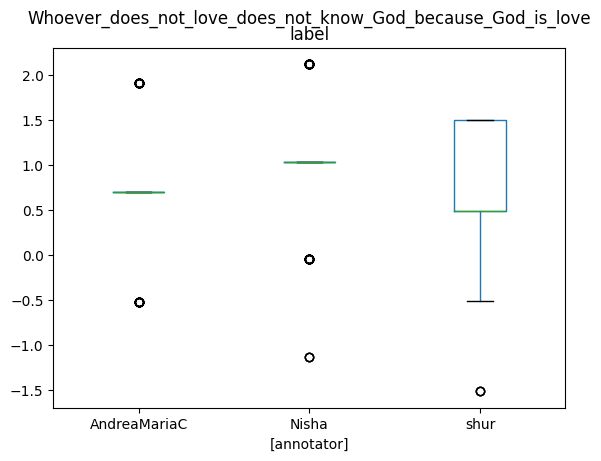

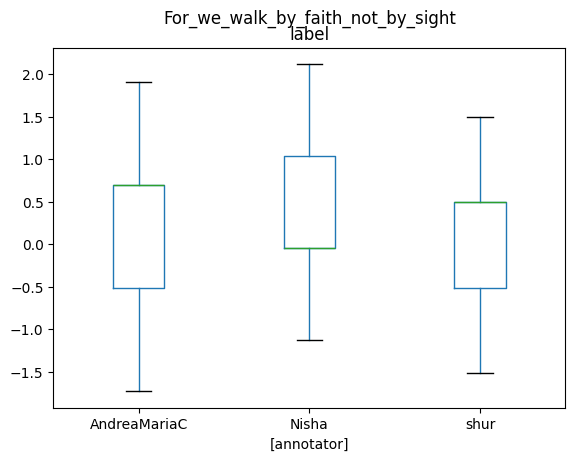

In [196]:
for lemma in tmp.lemma.unique():
    axes = tmp[tmp['lemma']==lemma][['annotator', 'label']].boxplot(by='annotator', grid=False)
    fig = axes.get_figure()
    fig.suptitle(lemma)

In [65]:
re.search('\(.*\)', df_judgments.instanceID.values[0]).group(0)

'(Hosea 8:7)'

In [55]:
rr = pd.read_csv('TRoTR/DURel_data/uses/(2 Corinthians 5:17).tsv', sep='\t')
for i,r in rr.iterrows():
    start, end = r['indexes_target_token'].split(':')
    start = int(start)
    end = int(end)
    if end > len(r['context']):
        print(r['context'], r['indexes_target_token'])

FileNotFoundError: [Errno 2] No such file or directory: 'TRoTR/DURel_data/uses/(2 Corinthians 5:17).tsv'

In [8]:
len("The lord is my Shepherd")

23